In [95]:
import pandas as pd
from pathlib import Path
import tqdm
import numpy as np
import sys
sys.path.append('/zliu_ssd/CHARM/upload/')
sys.path.append('/zliu_ssd/CHARM/upload/CHARMtools')
from scipy.stats import spearmanr
import cooler
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_3832548/315551334.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [96]:
def _generate_genomic_intervals(chrom_sizes:str,resolutions=500): 
    #return a bed-like dataframe
    chrom_sizes = pd.read_csv(chrom_sizes,sep="\t",header=None)
    chrom_sizes.columns = ["chr","size"]
    #keep writing
    intervals = []
    for index, row in chrom_sizes.iterrows():
        chr_name = row["chr"]
        chr_size = row["size"]
        for i in range(0,chr_size,resolutions):
            intervals.append([chr_name,i,i+resolutions])
    intervals_df = pd.DataFrame(intervals,columns=["chr","start","end"])
    return intervals_df

def _bedgraph_to_dense(bedgraph,chrom_sizes:str,resolution = 500):
    genome_intervals = _generate_genomic_intervals(chrom_sizes,resolution)
    dense = pd.merge(genome_intervals,bedgraph,how="left",on=["chr","start","end"])
    dense = dense.fillna(0)
    dense = dense[["chr","start","end","count"]]
    return dense


In [97]:
metadata = pd.read_csv("/zliu_ssd/CHARM/CHARM_mesc/data/metadata/metadata.tsv", sep="\t")
cellnames = metadata['cellname'].values

cg_100k = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/CpG/normal_cpg/M23.CpG.100000.txt", sep="\t", header=None)
cg_100k = cg_100k[cg_100k[0].isin([f'chr{i}' for i in range(1,20)])]
cg_100k.columns = ['chr', 'start', 'end','count']
# keep only chr1-19

In [98]:
#cg_100k
cg_100k = _bedgraph_to_dense(cg_100k, "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.len", resolution=100000)
cg_100k.columns = ['chrom', 'start', 'end','CpG']

In [99]:
# cellname = 'P4079'
# resolution = 100000
# frag_cell = pd.read_csv(f"/zliu_ssd/CHARM/CHARM_mesc/data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", sep="\t", header=None)
# frag_cell.columns = ['chrom', 'start', 'end','allele','score','strand']
# frag_cell = frag_cell[frag_cell['chrom'].isin([f'chr{i}' for i in range(1,20)])]
# # get count in 100kb res, start = start//100000*100000, end = start + 100000
# frag_cell['start_100k'] = frag_cell['start']//resolution*resolution
# frag_cell['end_100k'] = frag_cell['start_100k'] + resolution
# frag_cell_100k = frag_cell.groupby(['chrom', 'start_100k', 'end_100k']).size().reset_index(name='count')
# frag_cell_100k = frag_cell_100k.merge(cg_100k[['chrom','start','end']], left_on=['chrom', 'start_100k', 'end_100k'], right_on=['chrom', 'start', 'end'], how='right')
# frag_cell_100k = frag_cell_100k[['chrom', 'start', 'end','count']].fillna(0)

In [100]:
# generate matrix of all cells
resolution = 100000  # 100 kb bins
frag_dir = Path("/zliu_ssd/CHARM/CHARM_mesc/data/fragments/ct_frags")
valid_chroms = cg_100k['chrom'].unique().tolist()

bin_index = pd.MultiIndex.from_frame(cg_100k[['chrom', 'start', 'end']])
bin_index.names = ['chrom', 'start', 'end']
bin_cell_matrix = pd.DataFrame(0, index=bin_index, columns=cellnames, dtype=int)

def counts_for_cell(cellname: str) -> pd.Series:
    """Return 100 kb binned fragment counts for a single cell."""
    frag_path = frag_dir / f"{cellname}.ct.frag.bed.gz"
    if not frag_path.exists():
        print(f"Fragment file not found for {cellname}, filling with zeros.")
        return pd.Series(0, index=bin_cell_matrix.index, dtype=int)

    frag_cell = pd.read_csv(
        frag_path,
        sep="	",
        header=None,
        usecols=[0, 1, 2],
        names=['chrom', 'start', 'end']
    )
    frag_cell = frag_cell[frag_cell['chrom'].isin(valid_chroms)]
    if frag_cell.empty:
        return pd.Series(0, index=bin_cell_matrix.index, dtype=int)

    frag_cell['start'] = (frag_cell['start'] // resolution) * resolution
    frag_cell['end'] = frag_cell['start'] + resolution

    counts = (
        frag_cell
        .groupby(['chrom', 'start', 'end'])
        .size()
        .rename('count')
    )

    return counts.reindex(bin_cell_matrix.index, fill_value=0).astype(int)

for cell in tqdm.tqdm(cellnames):
    bin_cell_matrix[cell] = counts_for_cell(cell)
    

bin_cell_matrix_cpm = bin_cell_matrix.copy()#.div(bin_cell_matrix.sum(axis=0), axis=1) * 1e6

100%|██████████| 805/805 [00:58<00:00, 13.66it/s]


In [101]:
midS_cells = metadata[metadata['cellcycle_phase'] == 'Early-S']['cellname'].values
s_baseline = bin_cell_matrix_cpm.loc[:, midS_cells].mean(axis=1).reset_index().rename(columns={0:'s_baseline'}).set_index(['chrom', 'start', 'end'])
deltaM = bin_cell_matrix_cpm.subtract(s_baseline['s_baseline'], axis=0)

In [102]:
SEED_Q = 0.8
BAND = 1          # 去除 |i-j|<=BAND 的近对角项，降低 1D 混杂
RW_STEPS = 0      # 随机游走步数，稀疏时可改为 2
EPS = 1e-12
chromosomes = [f'chr{i}' for i in range(1, 20)]

_clr_cache = {}

def open_clr(cell):
    BASE = "/zliu_ssd/CHARM/CHARM_mesc/data/cools"
    TEMPLATE = "{BASE}/{cell}.mcool::/resolutions/100000"
    uri = TEMPLATE.format(BASE=BASE, cell=cell)
    return cooler.Cooler(uri)

def get_clr(cell):
    """Reuse cooler handles per cell to avoid reopening files."""
    if cell not in _clr_cache:
        _clr_cache[cell] = open_clr(cell)
    return _clr_cache[cell]

def preprocess_contact(M, band=BAND, rw_steps=RW_STEPS, eps=EPS):
    M = M.astype(float).copy()
    N = M.shape[0]
    # 去对角 & 去超短程
    idx = np.arange(N)
    band_mask = (np.abs(idx[:, None] - idx[None, :]) <= band)
    M[band_mask] = 0.0

    rowsum = M.sum(axis=1, keepdims=True)
    P = np.divide(M, rowsum + eps, where=rowsum > 0)

    #P = imputation.schicluster_imputation_for_mat(M)
    
    # for _ in range(max(0, rw_steps - 1)):
    #     P = P @ P
    #     rowsum = P.sum(axis=1, keepdims=True)
    #     P = np.divide(P, rowsum + eps, where=rowsum > 0)
    return P


In [103]:
sys.path.append('/zliu_ssd/CHARM/upload/CHARMtools/analysis')

In [104]:
chrom_results = []

for chrom_process in chromosomes:
    # ==== 取本条染色体的基线、种子、ΔM，并确保顺序一致 ====
    B_chr_df = s_baseline.loc[chrom_process].copy()                # index: (start,end)
    B_chr = B_chr_df['s_baseline'].astype(float).to_numpy()        # shape (N,)
    seed_vec = (B_chr >= np.quantile(B_chr, SEED_Q)).astype(float)

    Delta_chr = deltaM.loc[chrom_process, list(cellnames)].copy()  # shape (N, C)
    bins_chr_index = Delta_chr.index                               # 保存 (start,end) MultiIndex
    N = len(bins_chr_index)
    C = len(cellnames)
    if N == 0:
        continue

    # ==== 计算每细胞的 s_{i,c} ====
    S_mat = np.zeros((N, C), dtype=float)

    for ci, cell in tqdm.tqdm(enumerate(cellnames), total=C, desc=chrom_process):
        clr = get_clr(cell)
        M = clr.matrix(balance=False).fetch(chrom_process)         # (N,N)
        P = preprocess_contact(M, band=BAND, rw_steps=RW_STEPS, eps=EPS)
        S_mat[:, ci] = P @ seed_vec                                # (N,)

    S_df_chr = pd.DataFrame(S_mat, index=bins_chr_index, columns=cellnames).fillna(0)

    chr_index = pd.MultiIndex.from_arrays(
        [
            np.repeat(chrom_process, N),
            bins_chr_index.get_level_values('start'),
            bins_chr_index.get_level_values('end')
        ],
        names=['chrom', 'start', 'end']
    )

    S_df_chr.index = chr_index
    Delta_chr.index = chr_index
    seed_series_chr = pd.Series(seed_vec, index=chr_index, name='Seed', dtype=float)

    chrom_results.append(
        {
            'chrom': chrom_process,
            'S_df': S_df_chr,
            'Delta_chr': Delta_chr,
            'Seed': seed_series_chr
        }
    )

S_df = pd.concat([res['S_df'] for res in chrom_results]).sort_index()
Delta_chr = pd.concat([res['Delta_chr'] for res in chrom_results]).sort_index()
seed_series = pd.concat([res['Seed'] for res in chrom_results]).sort_index()


chr19: 100%|██████████| 805/805 [00:18<00:00, 43.28it/s]


In [105]:
# G2_cellnames=metadata[metadata['cellcycle_phase']]['cellname'].values
selected_cells = metadata[metadata['cellcycle_phase'].isin(["Late-S","G2"])]['cellname']
selected_cells = [c for c in selected_cells if c in S_df.columns]


In [106]:
selected_S = S_df.loc[:, selected_cells]
selected_Delta = Delta_chr.loc[:, selected_cells]

s_all = selected_S.stack()
q = s_all.quantile([0.2, 0.4, 0.6, 0.8]).values
cuts = pd.cut(s_all, bins=[-np.inf, *q, np.inf], labels=['Q1','Q2','Q3','Q4','Q5'])

delta_all = selected_Delta.stack().rename('DeltaM')
df_long = pd.concat([cuts.rename('s_bin'), delta_all], axis=1).dropna()
df_long['chrom'] = df_long.index.get_level_values('chrom')

# 各分位箱的均值/标准误
summary = df_long.groupby('s_bin')['DeltaM'].agg(['mean','count','std'])
summary['se'] = summary['std'] / np.sqrt(summary['count'])
print("ΔM vs s 分位箱统计：")
print(summary)


ΔM vs s 分位箱统计：
           mean   count       std        se
s_bin                                      
Q1     0.385723  951402  2.095229  0.002148
Q2     0.586902  951408  2.437352  0.002499
Q3     0.800481  950468  2.778832  0.002850
Q4     1.285833  951257  3.381122  0.003467
Q5     2.074140  950792  4.174423  0.004281


/tmp/ipykernel_3832548/2732075105.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_long.groupby('s_bin')['DeltaM'].agg(['mean','count','std'])


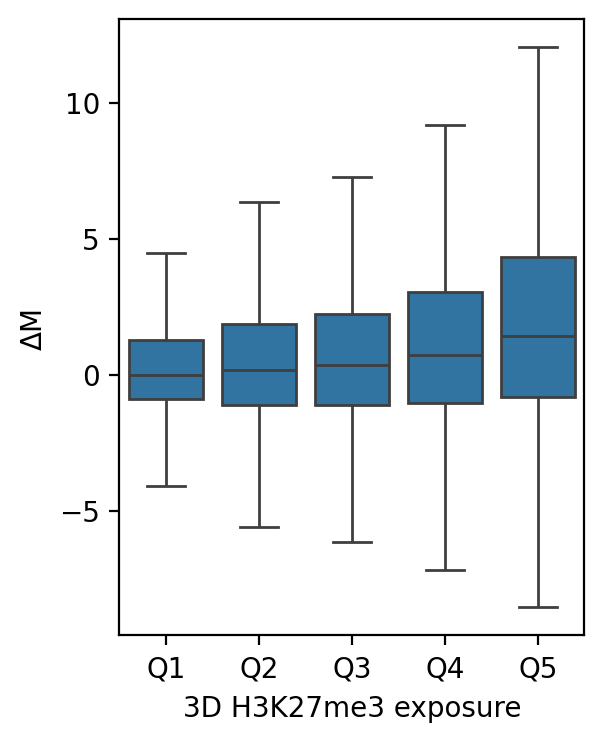

In [107]:
# plot deltaM vs s, boxplot
fig = plt.figure(figsize=(3,4))
sns.boxplot(data=df_long, x='s_bin', y='DeltaM', order=['Q1','Q2','Q3','Q4','Q5'], showfliers=False)    
plt.xlabel('3D H3K27me3 exposure')
plt.ylabel('ΔM')

plt.savefig("deltaM_vs_s_boxplot.pdf")

In [108]:
cors = []
cors_sc_shuffle = []
for c in selected_cells:
    v1 = selected_Delta[c].values
    v2 = selected_S[c].values
    mask = np.isfinite(v1) & np.isfinite(v2)
    rho, p = spearmanr(v1[mask], v2[mask])
    cors.append(rho)
    # shuffle control
    v2_shuffle = selected_S[random.choice(selected_cells)].values
    rho_shuffle, p_shuffle = spearmanr(v1[mask], v2_shuffle[mask])
    cors_sc_shuffle.append(rho_shuffle)
cors_series = pd.Series(cors, index=selected_cells, name='spearman_rho')
print("单细胞 Spearman 相关的描述统计：")
print(cors_series.describe())

cors_sc_shuffle_series = pd.Series(cors_sc_shuffle, index=selected_cells, name='spearman_rho_shuffle')
print("单细胞 Spearman 相关（shuffle）的描述统计：")
print(cors_sc_shuffle_series.describe())


单细胞 Spearman 相关的描述统计：
count    193.000000
mean       0.152936
std        0.135729
min       -0.384325
25%        0.075641
50%        0.170232
75%        0.250149
max        0.405112
Name: spearman_rho, dtype: float64
单细胞 Spearman 相关（shuffle）的描述统计：
count    193.000000
mean       0.143484
std        0.134766
min       -0.393748
25%        0.068960
50%        0.157434
75%        0.235757
max        0.399110
Name: spearman_rho_shuffle, dtype: float64


Text(0.5, 0, 'Spearman correlation (ΔM vs s)')

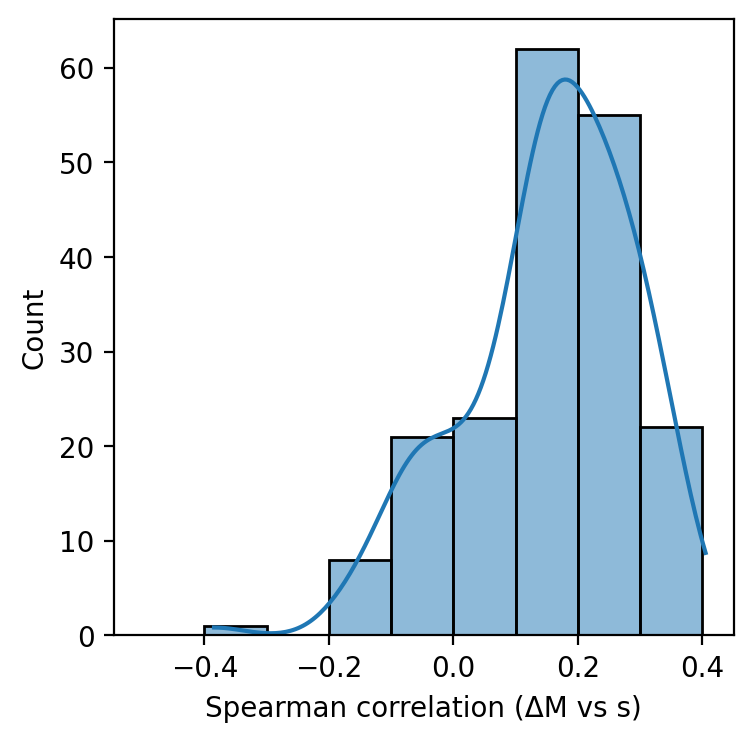

In [109]:
# histogram of cors
fig = plt.figure(figsize=(4,4))
bins = np.arange(-0.5, 0.5, 0.1)
sns.histplot(cors_series, bins=bins, kde=True)
#sns.histplot(cors_sc_shuffle_series, bins=bins, kde=True, color='orange', alpha=0.5)
plt.xlabel('Spearman correlation (ΔM vs s)')
# save figure


In [110]:
# wilcoxon test
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(cors_series, cors_sc_shuffle_series)
print(f"\nWilcoxon test between actual and shuffled correlations: statistic={stat}, p-value={p_value}")


Wilcoxon test between actual and shuffled correlations: statistic=529.0, p-value=9.37898899521849e-30


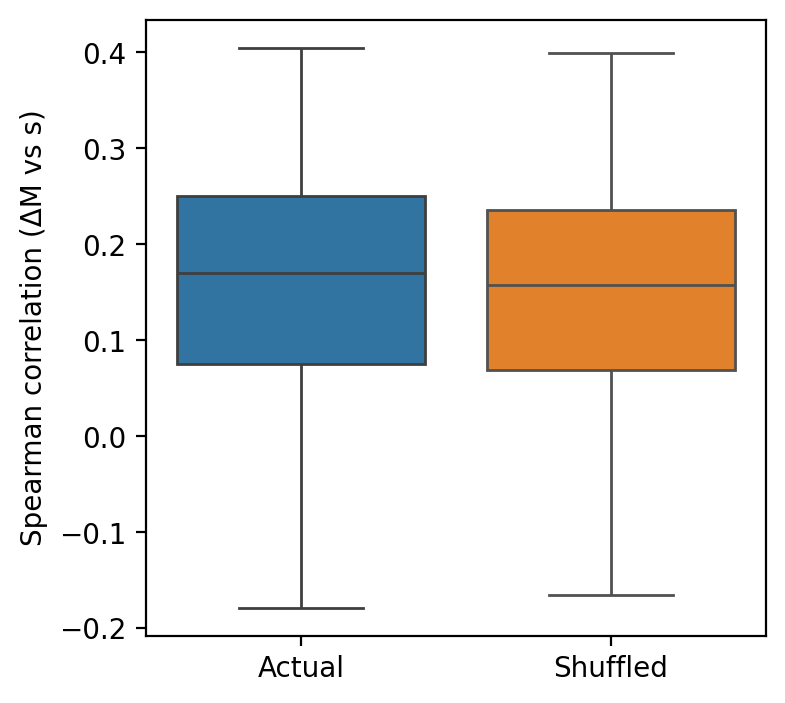

In [111]:
# boxplot of cors, x = cors, shuf cors
fig = plt.figure(figsize=(4,4))
sns.boxplot(data=cors_series.to_frame().reset_index(),x=0, y='spearman_rho',showfliers=False)
sns.boxplot(data=cors_sc_shuffle_series.to_frame().reset_index(), x=1,y='spearman_rho_shuffle', showfliers=False)  
plt.xticks([0,1], ['Actual','Shuffled'])
plt.ylabel('Spearman correlation (ΔM vs s)')
plt.show()

In [112]:
import statsmodels.formula.api as smf

In [113]:
# Select Late-S + G2 cells
LateS_G2_cells = metadata[metadata['cellcycle_phase'].isin(["Late-S", "G2"])]['cellname']
LateS_G2_cells = [c for c in LateS_G2_cells if c in Delta_chr.columns]
Delta_chr_LateS_G2 = Delta_chr.loc[:, LateS_G2_cells]
S_df_LateS_G2 = S_df.loc[:, LateS_G2_cells]

# 1D covariate: log distance to nearest seed (by chromosome)
dlog_parts = []
for chrom in chromosomes:
    seed_chr = seed_series.xs(chrom, level='chrom')
    if seed_chr.empty:
        continue
    N_chr = len(seed_chr)
    seed_values = seed_chr.to_numpy()
    if np.any(seed_values > 0):
        idx = np.arange(N_chr, dtype=int)
        dist_bins = np.full(N_chr, np.inf, dtype=float)
        seed_pos = np.flatnonzero(seed_values > 0)
        for pos in seed_pos:
            dist_bins = np.minimum(dist_bins, np.abs(idx - pos))
    else:
        dist_bins = np.full(N_chr, np.nan, dtype=float)

    starts = seed_chr.index.get_level_values('start').to_numpy()
    starts_unique = np.unique(starts)
    if len(starts_unique) > 1:
        bin_size = int(np.median(np.diff(np.sort(starts_unique))))
    else:
        bin_size = resolution
    d_log_vec = np.log1p(dist_bins * bin_size)

    idx_chr = pd.MultiIndex.from_arrays(
        [
            np.repeat(chrom, N_chr),
            seed_chr.index.get_level_values('start'),
            seed_chr.index.get_level_values('end')
        ],
        names=['chrom', 'start', 'end']
    )
    dlog_parts.append(pd.Series(d_log_vec, index=idx_chr))

dlog_by_bin = pd.concat(dlog_parts) if dlog_parts else pd.Series(dtype=float)

# 3D covariate: actual vs randomised contacts
rng = np.random.default_rng(0)
random_pick = pd.Series(rng.choice(LateS_G2_cells, size=len(LateS_G2_cells), replace=True), index=LateS_G2_cells)
S_df_random = pd.DataFrame({cell: S_df_LateS_G2[random_pick[cell]] for cell in LateS_G2_cells})
S_df_random = S_df_random.reindex_like(S_df_LateS_G2)

s_long = S_df_LateS_G2.stack(dropna=False).rename('s')
s_random_long = S_df_random.stack(dropna=False).rename('s_random')
dm_long = Delta_chr_LateS_G2.stack(dropna=False).rename('DeltaM')

df = pd.concat([s_long, s_random_long, dm_long], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
df = df.query('DeltaM != 0').reset_index()

bin_pairs = pd.MultiIndex.from_frame(df[['chrom', 'start', 'end']])
df['d_log'] = dlog_by_bin.reindex(bin_pairs).to_numpy()
df = df.dropna(subset=['d_log'])

df = df.merge(cg_100k[['chrom', 'start', 'end', 'CpG']], on=['chrom', 'start', 'end'], how='left')

# m1 = smf.mixedlm("DeltaM ~ d_log", data=df, groups=df["level_3"]).fit(method='lbfgs')
# m2 = smf.mixedlm("DeltaM ~ s + d_log", data=df, groups=df["level_3"]).fit(method='lbfgs')
# m3 = smf.mixedlm("DeltaM ~ s_random + d_log", data=df, groups=df["level_3"]).fit(method='lbfgs')

m1 = smf.mixedlm("DeltaM ~ d_log", data=df, groups=df["level_3"]).fit(method='lbfgs')
m2 = smf.mixedlm("DeltaM ~ s", data=df, groups=df["level_3"]).fit(method='lbfgs')
m3 = smf.mixedlm("DeltaM ~ s_random", data=df, groups=df["level_3"]).fit(method='lbfgs')


preds = {
    '1D': m1.predict(df),
    '3D': m2.predict(df),
    '3D_random': m3.predict(df)
}

mse = {name: np.mean((df['DeltaM'] - pred)**2) for name, pred in preds.items()}


/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter v

In [ ]:
# Predict with fitted models and gather per-cell mean squared errors
pred1 = preds['1D']
pred2 = preds['3D']
pred3 = preds['3D_random']

tmp = df.copy()
tmp['sqerr_1D'] = (tmp['DeltaM'] - pred1) ** 2
tmp['sqerr_1D3D_real'] = (tmp['DeltaM'] - pred2) ** 2
tmp['sqerr_1D3D_random'] = (tmp['DeltaM'] - pred3) ** 2

cell_mse = tmp.groupby('level_3')[['sqerr_1D', 'sqerr_1D3D_real', 'sqerr_1D3D_random']].mean()

from scipy.stats import wilcoxon

def wilcoxon_safe(series):
    arr = series.to_numpy()
    if np.allclose(arr, 0):
        return 0.0, 1.0
    return wilcoxon(arr)

diff_real = cell_mse['sqerr_1D'] - cell_mse['sqerr_1D3D_real']
diff_random = cell_mse['sqerr_1D'] - cell_mse['sqerr_1D3D_random']
diff_real_vs_random = cell_mse['sqerr_1D3D_random'] - cell_mse['sqerr_1D3D_real']

_, p_real = wilcoxon_safe(diff_real)
_, p_random = wilcoxon_safe(diff_random)
_, p_real_vs_random = wilcoxon_safe(diff_real_vs_random)

print(f"Median ΔMSE (1D - 3D real): {diff_real.median():.3f}, Wilcoxon p = {p_real:.2e}")
print(f"Median ΔMSE (1D - 3D random): {diff_random.median():.3f}, Wilcoxon p = {p_random:.2e}")
print(f"Median ΔMSE (3D random - 3D real): {diff_real_vs_random.median():.3f}, Wilcoxon p = {p_real_vs_random:.2e}")


Median ΔMSE (1D - 1D+3D real): 5.287, Wilcoxon p = 2.06e-31
Median ΔMSE (1D - 1D+3D random): 5.202, Wilcoxon p = 1.61e-31
Median ΔMSE (1D+3D random - 1D+3D real): 0.044, Wilcoxon p = 6.14e-15


/tmp/ipykernel_3832548/4064033353.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


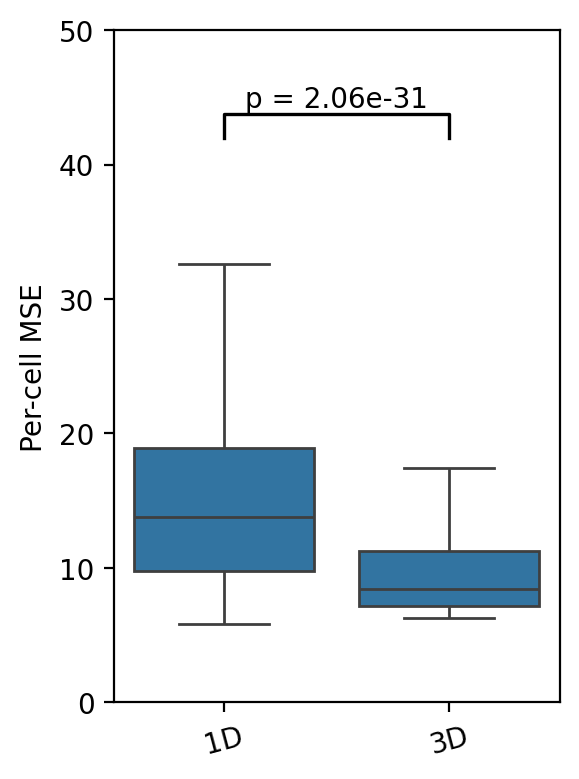

In [ ]:
# Per-cell MSE boxplot with p-value annotations
plot_df = cell_mse[['sqerr_1D', 'sqerr_1D3D_real']].rename(columns={
    'sqerr_1D': '1D',
    'sqerr_1D3D_real': '3D'
}).reset_index(drop=True).melt(var_name='model', value_name='mse')

order = ['1D', '3D']

fig, ax = plt.subplots(figsize=(3, 4))
sns.boxplot(data=plot_df, x='model', y='mse', order=order, showfliers=False, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Per-cell MSE')

def add_significance(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, color='k')
    ax.text((x1 + x2) / 2, y + h * 1.05, text, ha='center', va='bottom', fontsize=10)

y_min = 0  # plot_df['mse'].min()
y_max = 35 #plot_df['mse'].max()
y_range = y_max - y_min if y_max > y_min else 1.0
base = y_max + 0.05 * y_range
height = 0.05 * y_range

add_significance(ax, 0, 1, base + 3 * height, height, f"p = {p_real:.2e}")

ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt. ylim(0,50)
plt.tight_layout()

plt.savefig("per_cell_mse_boxplot.pdf")

plt.show()
